In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import product

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

### インスタンス数は一つのみなので，host数が増えた場合には少し改変が必要

In [11]:
df_lst = []

train_dir = Path("../raw_dataset/")
for data_dir in train_dir.iterdir():
    data_dict = {}
    json_paths = data_dir.glob("*.json")
    for path in json_paths:
        with open(path, "r") as f:
            metric = path.name[:-24]
            results = json.load(f)["results"]
            metric_set = set()
            for src_data in results:
                for data in src_data["data"]:
                    metric_set.add(data["metric"])
            for src_data in results:
                if src_data["source"][:10] != "summarizer":
                    for data in src_data["data"]:
                        # jsonのキーは順番保証されていないので，念の為ソート
                        tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "origin"]
                        key_name = metric
                        # metricフィールドが全て同じならキー名に含めない
                        if len(metric_set) > 1:
                            # metricフィールドの冗長な名前を簡潔化
                            metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                            key_name += f"-{metric_attr}"
                        if len(tags) > 0:
                            key_name += f"-{'-'.join(tags)}"
                        data_dict[key_name] = data["NumericType"]
    df = pd.DataFrame(data_dict, dtype="float32")
    df.dropna(inplace=True)
    # HACK: 
    df.drop(1, axis=0, inplace=True)
    # rm_indices = []
    # prev_val = 0
    # for idx in range(1, len(df) + 1):
    #     val = df["innodb_io_capacity"][idx]
    #     if val != prev_val:
    #         rm_indices.append(idx)
    #         if idx < len(df):
    #             rm_indices.append(idx + 1)
    #         if idx > 1:
    #             rm_indices.append(idx - 1)
    #     prev_val = val
    # df.drop(rm_indices, axis=0, inplace=True)
    df_lst.append(df)

In [12]:
tmp_df = df_lst[0]
print(tmp_df.filter(like="query-").columns)

Index(['query-create_table', 'query-insert', 'query-delete', 'query-select',
       'query-commit', 'query-alter_table', 'query-drop_index', 'query-update',
       'query-replace', 'query-drop_table'],
      dtype='object')


oltp_read_write_low


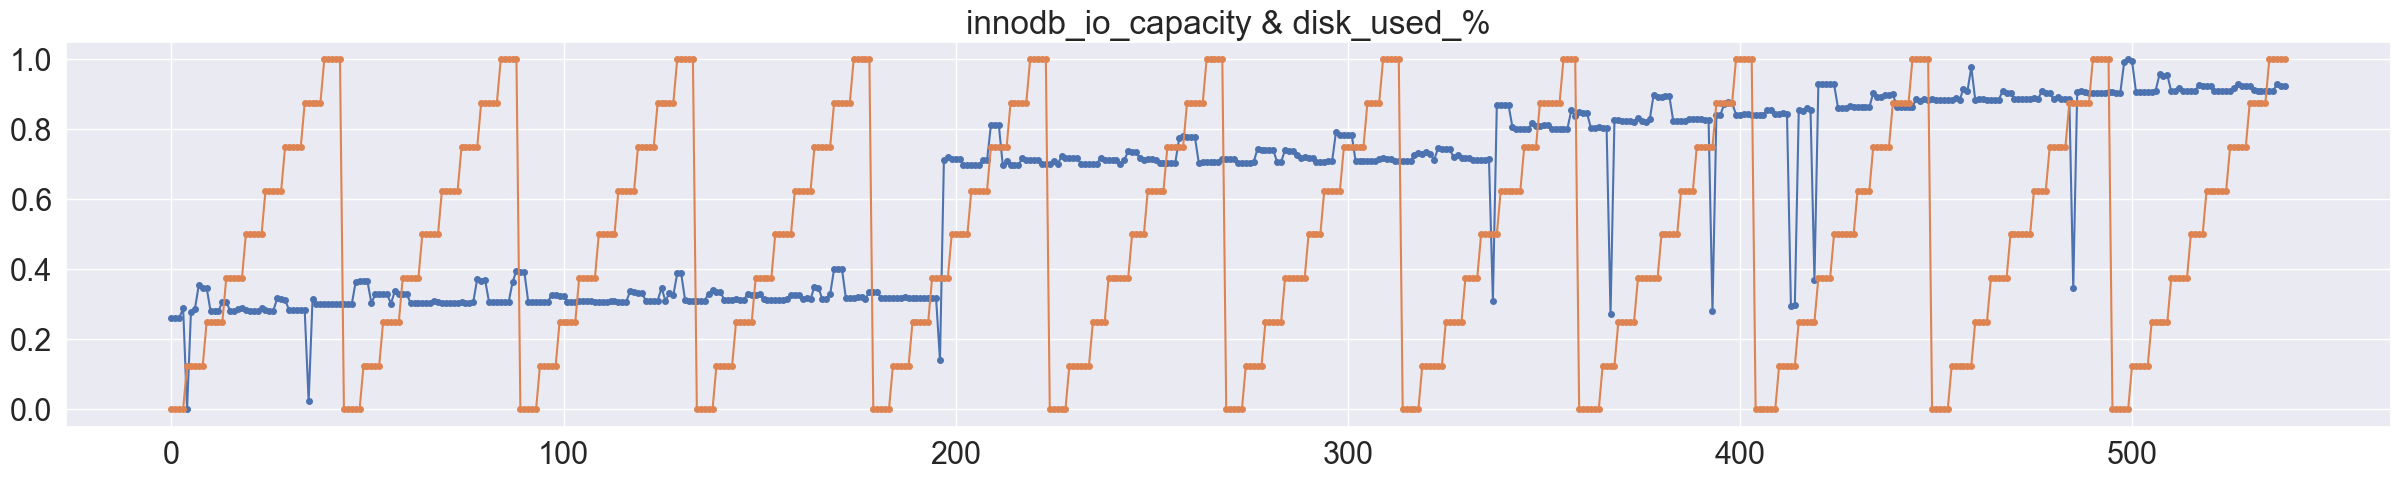




oltp_read_only_low


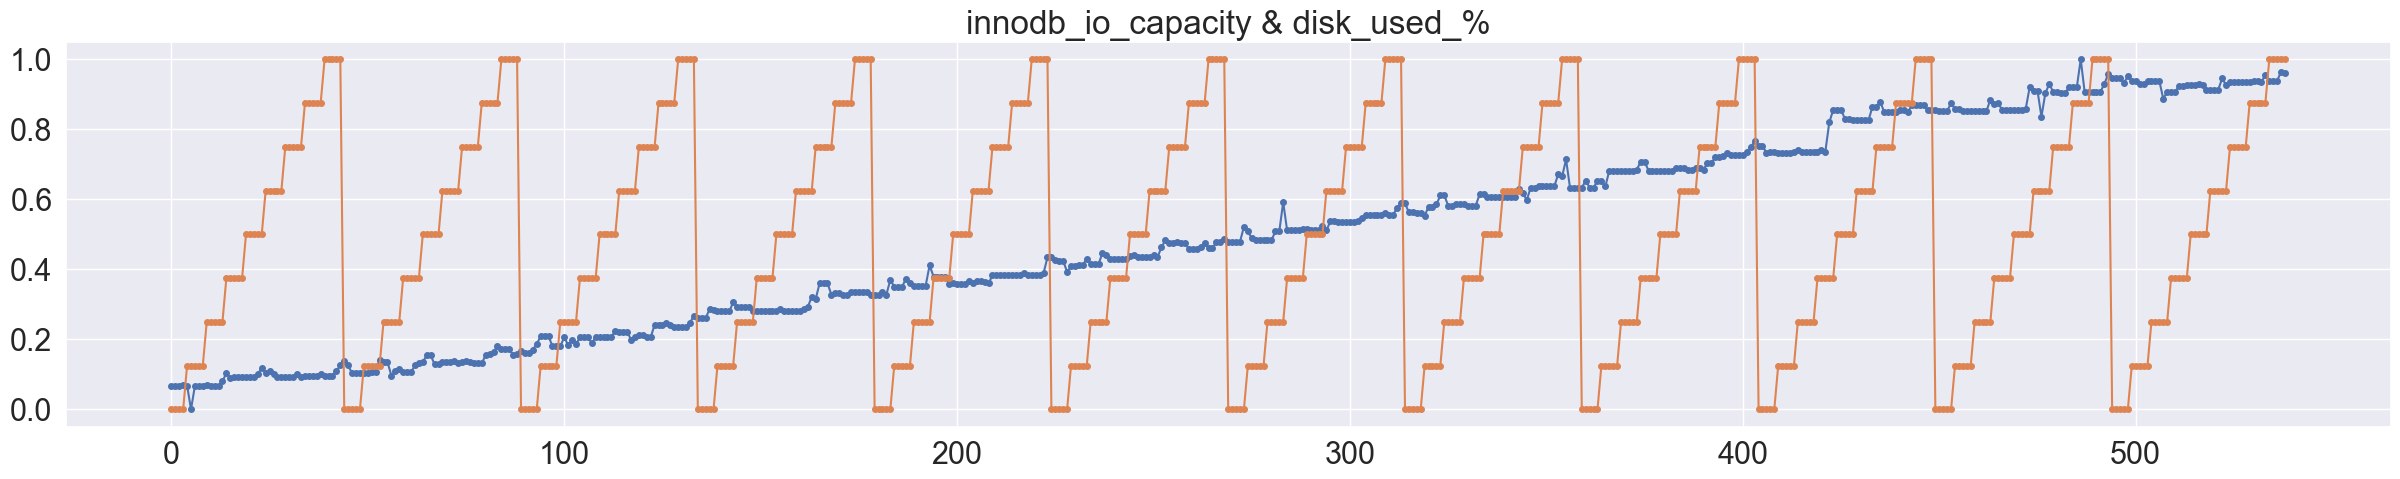




tpcc_medium


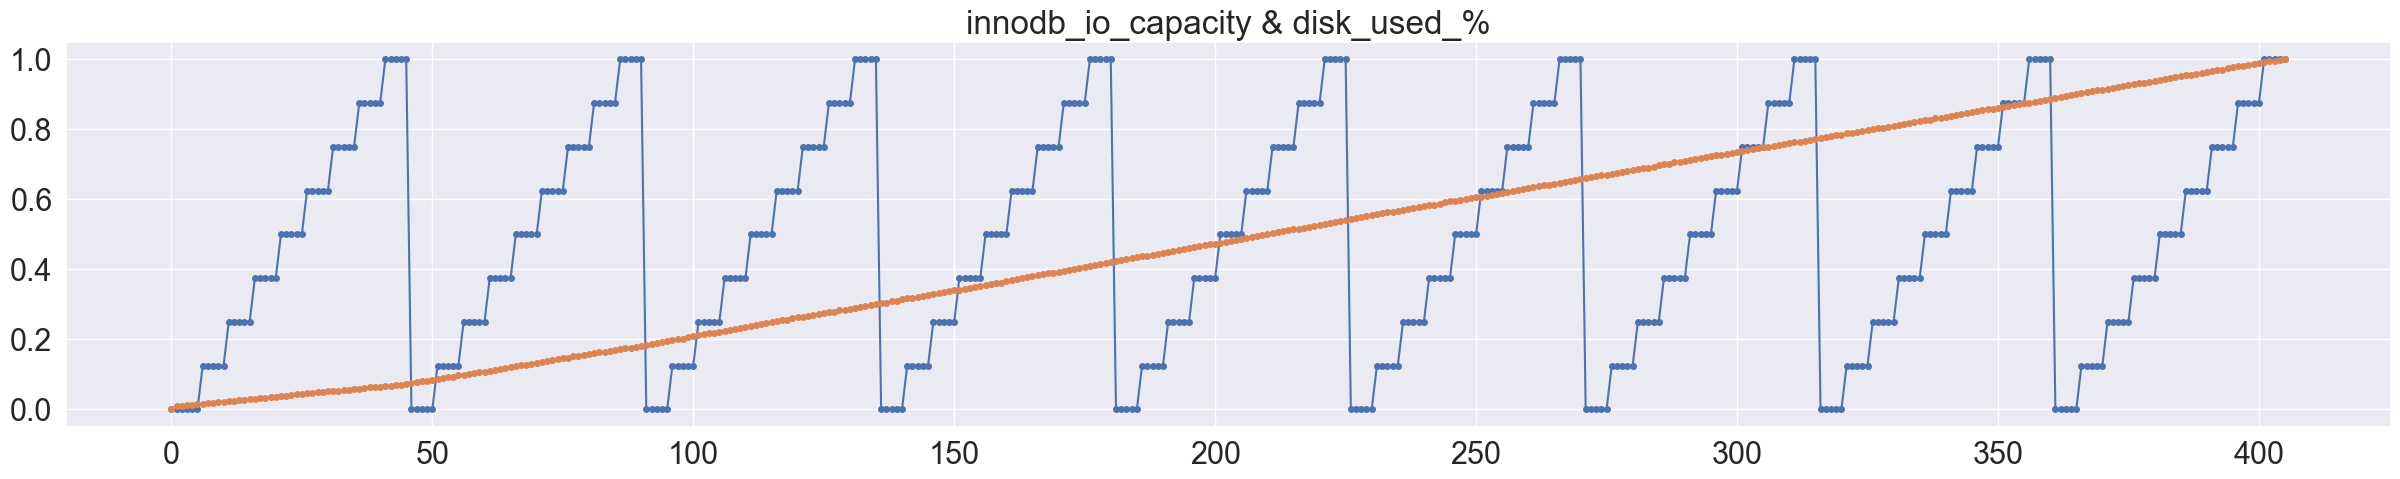




tpcc_low


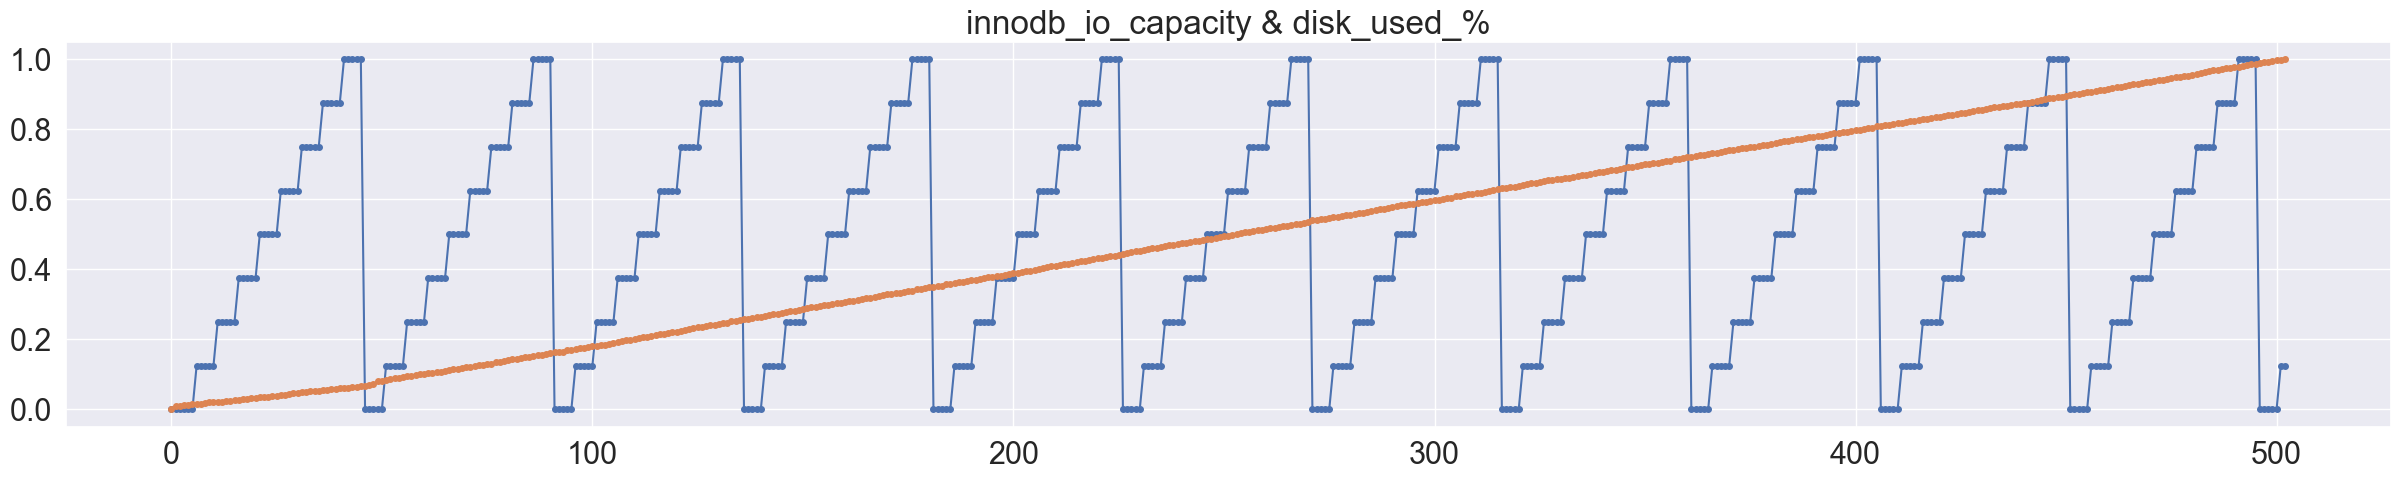




oltp_write_only_medium


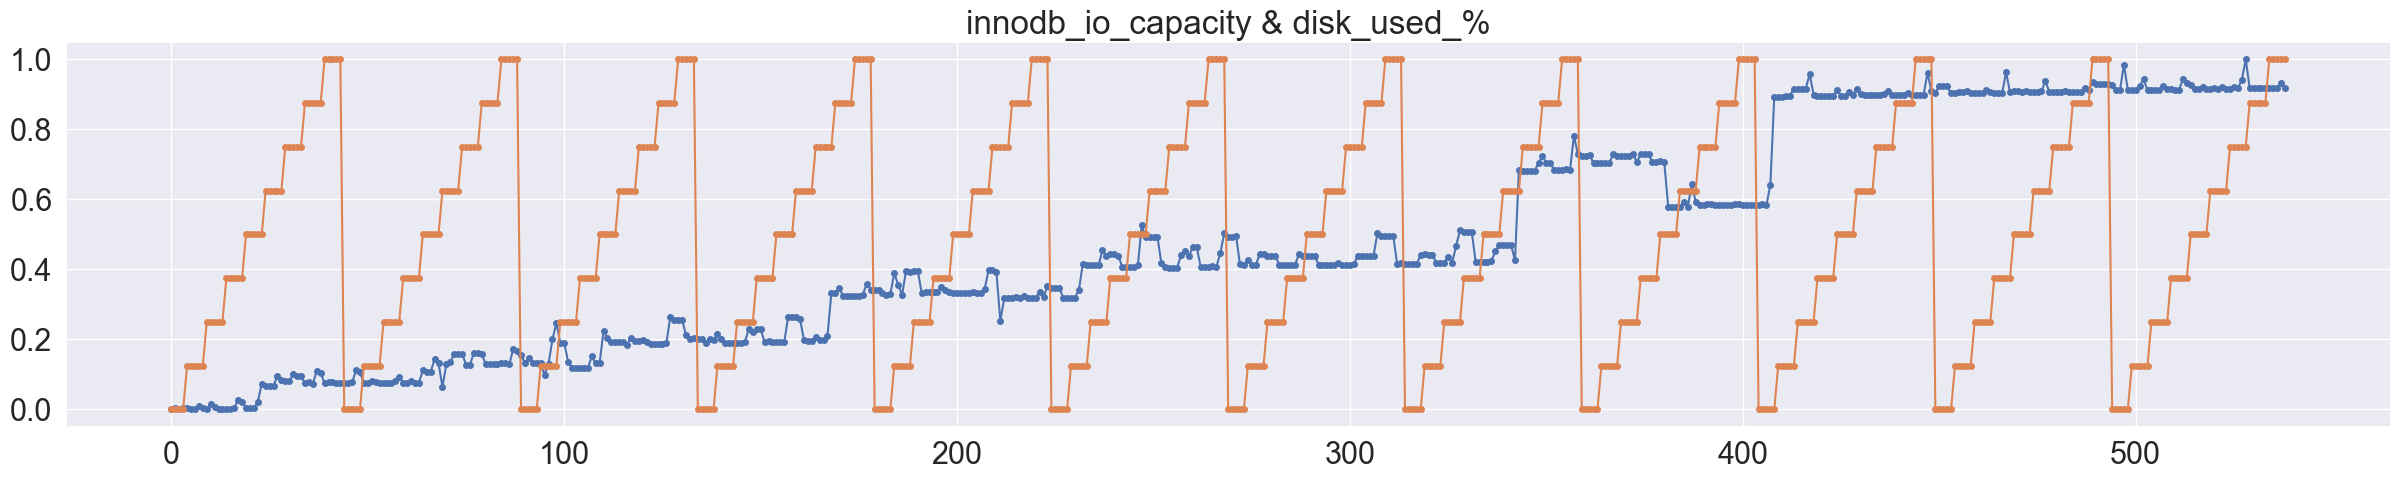




oltp_write_only_low


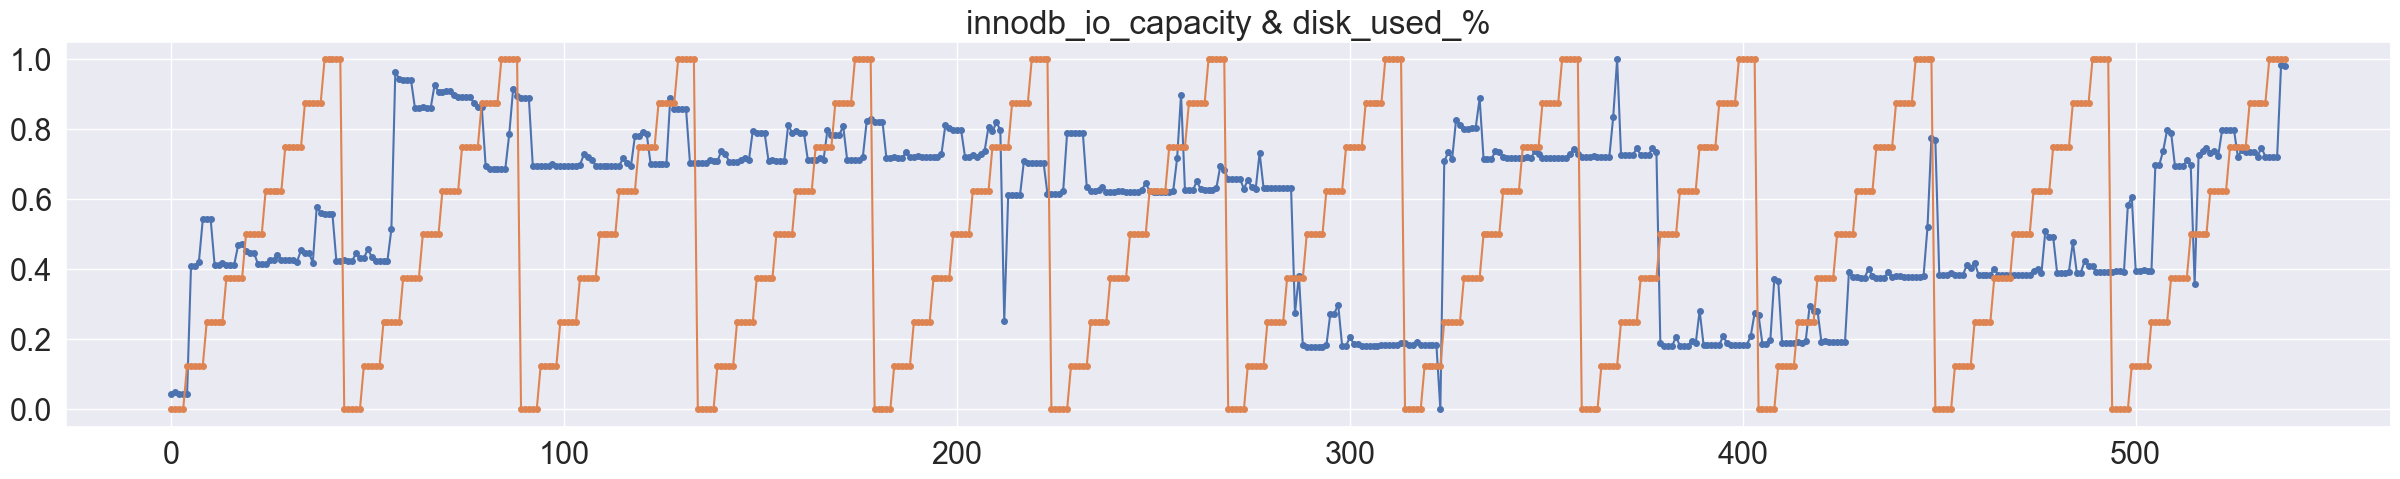




oltp_read_only_medium


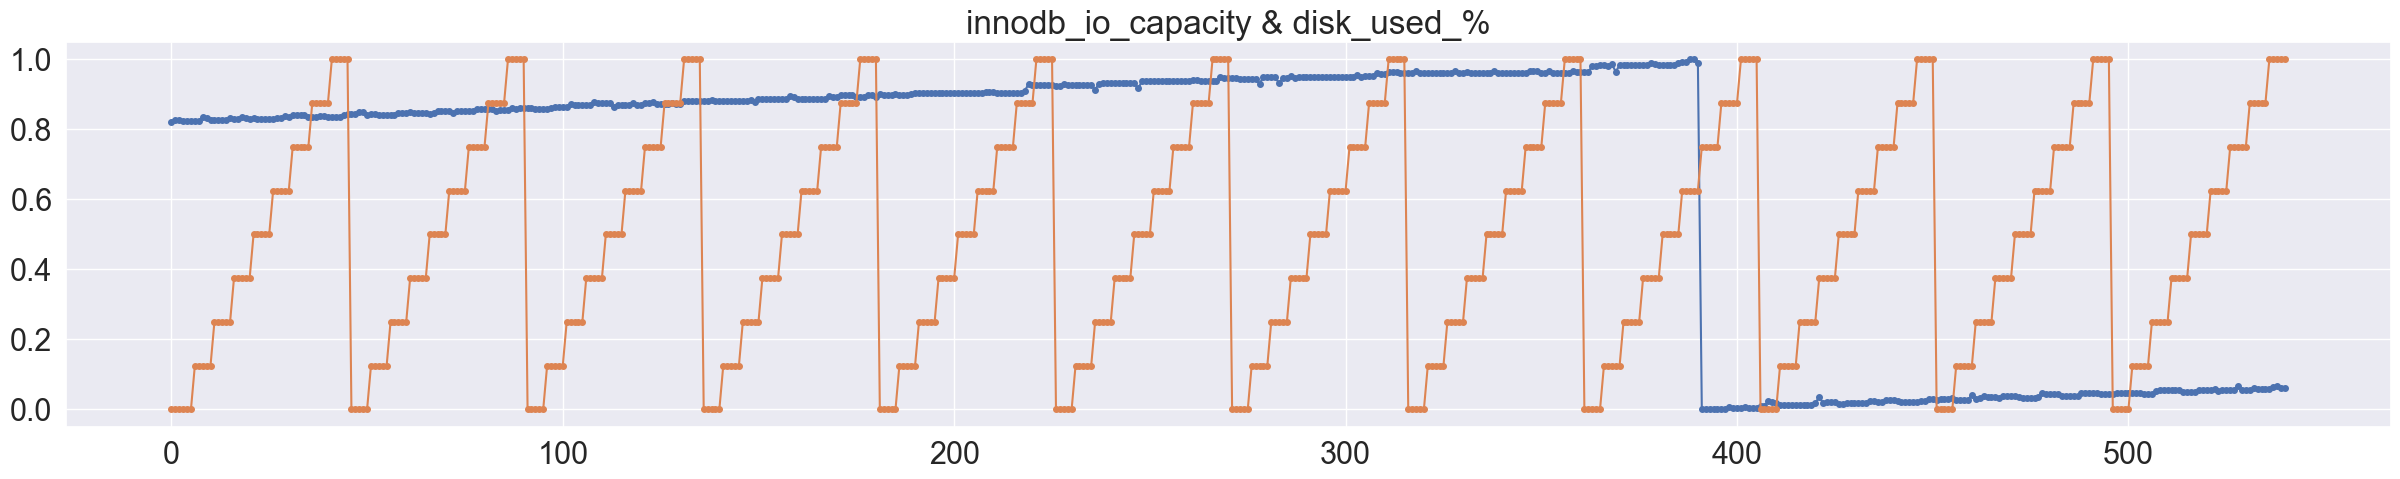

In [165]:
def normalize(df, col_name):
    max_val = max(df[col_name])
    min_val = min(df[col_name])
    return (df[col_name] - min_val) / (max_val - min_val)

for dir_name, tmp_df in zip(train_dir.iterdir(), df_lst):
    print("=====================================================")
    print(f"{dir_name.name}")
    print("=====================================================")
    tmp_df = tmp_df.loc[:, tmp_df.nunique() != 1] # 値が一定のメトリックを除く
    plt.figure(figsize=(30, 5))
    for col_name in tmp_df.columns:
        if col_name in {"disk_used_%", "innodb_io_capacity"}:
            plt.plot(range(len(tmp_df)), normalize(tmp_df, col_name), 'o-', markersize=4)
            plt.title("innodb_io_capacity & disk_used_%")
    plt.show()
    print('\n\n')

oltp_read_write_low


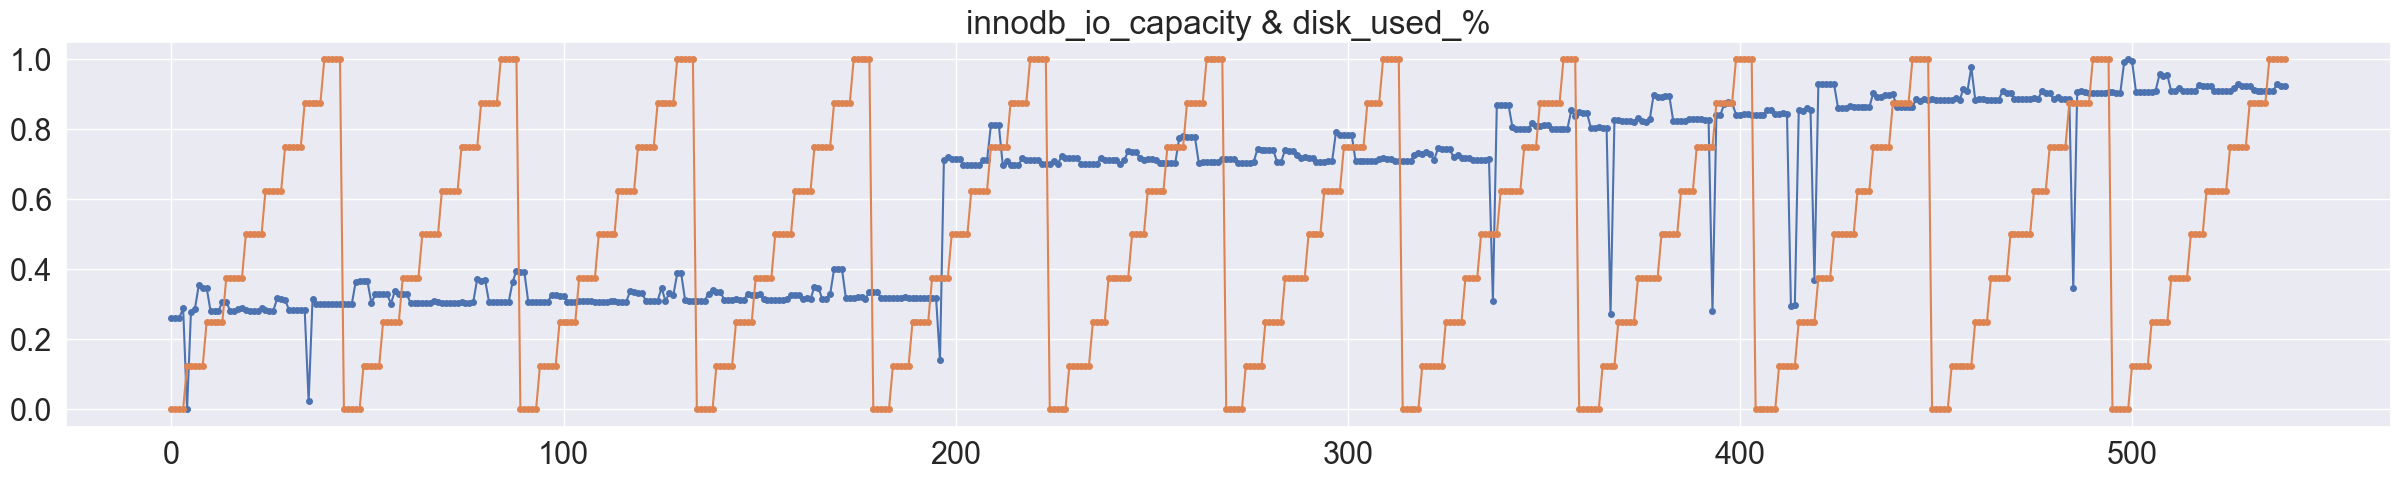




oltp_read_only_low


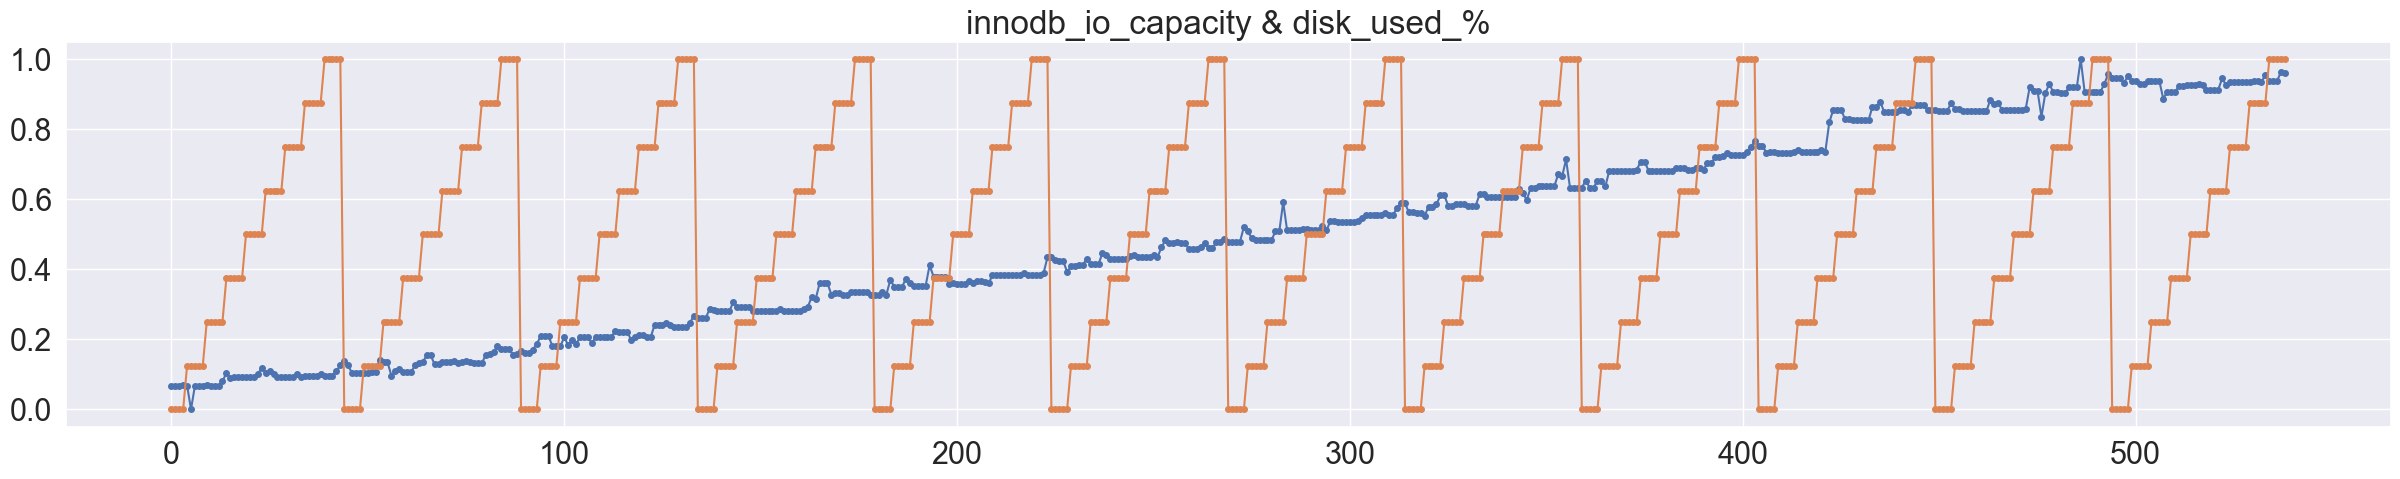




tpcc_medium


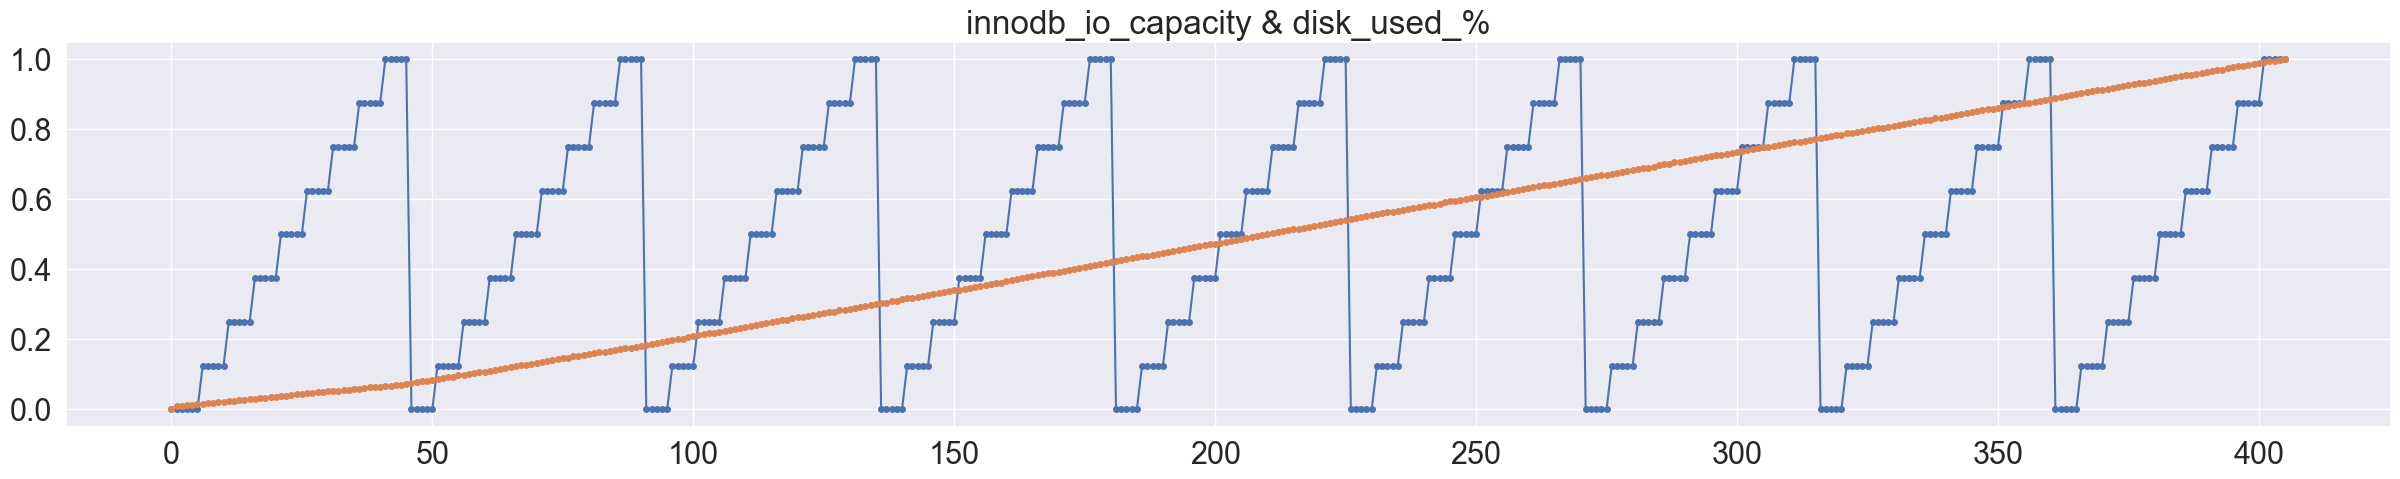




tpcc_low


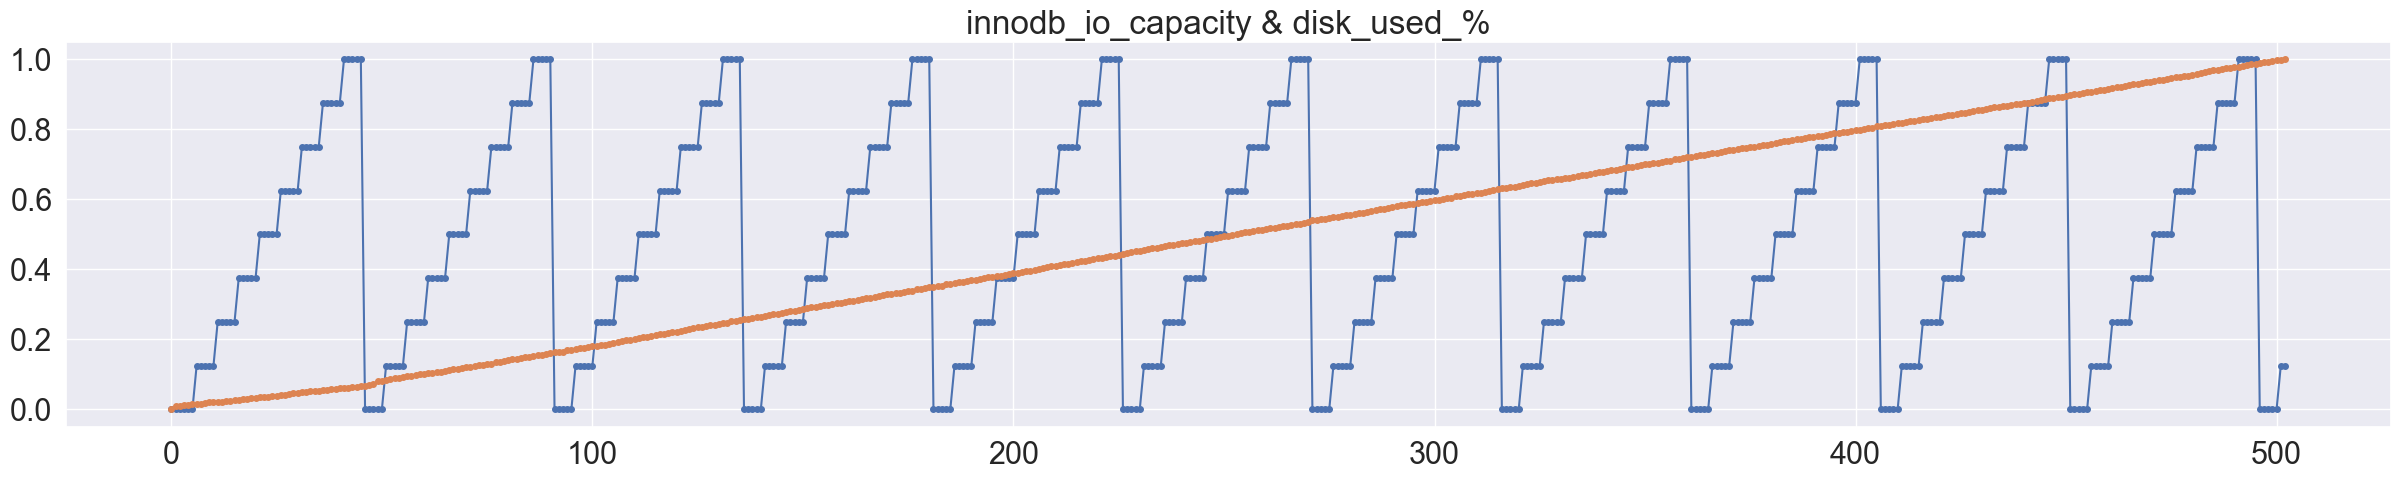




oltp_write_only_medium


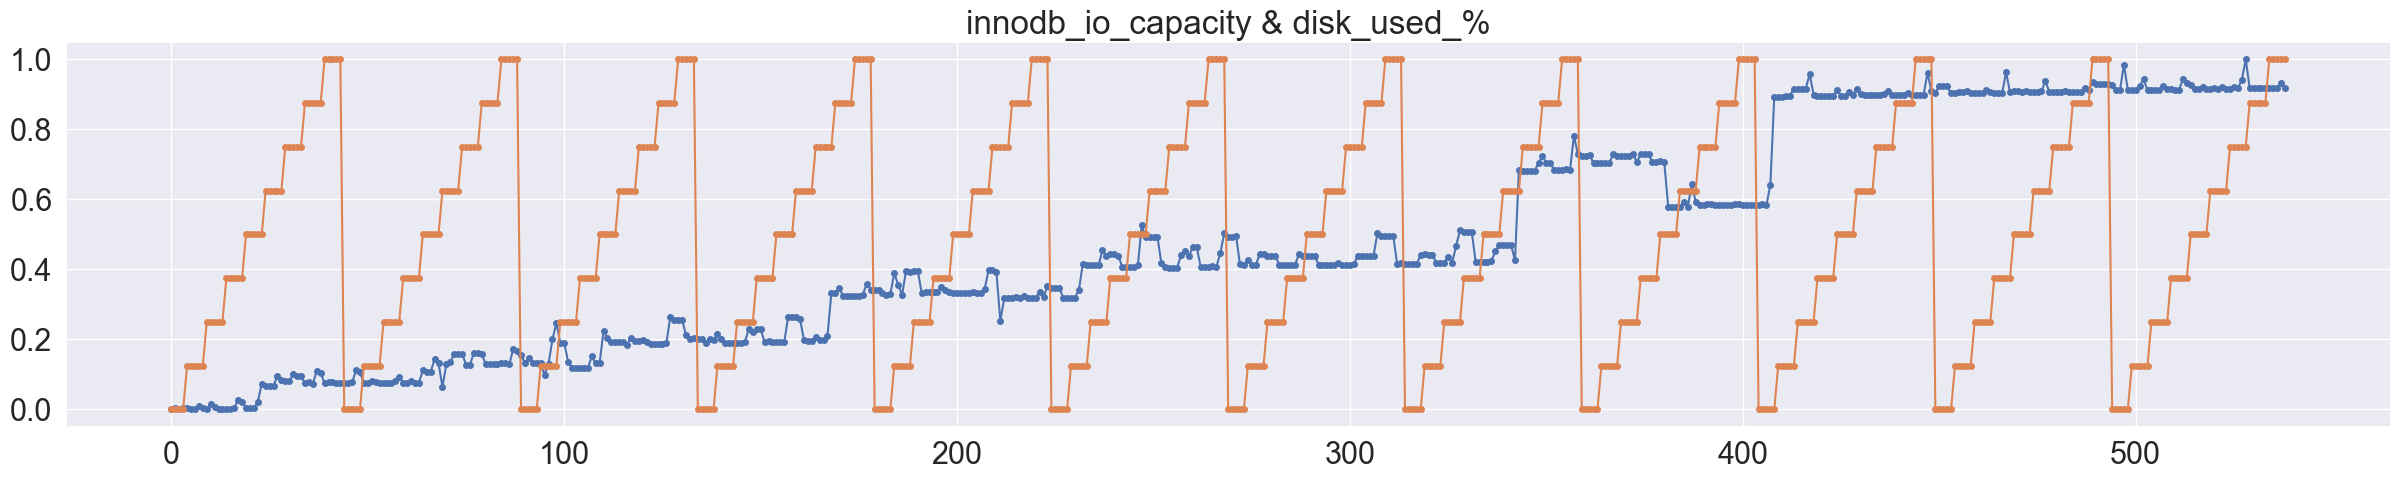




oltp_write_only_low


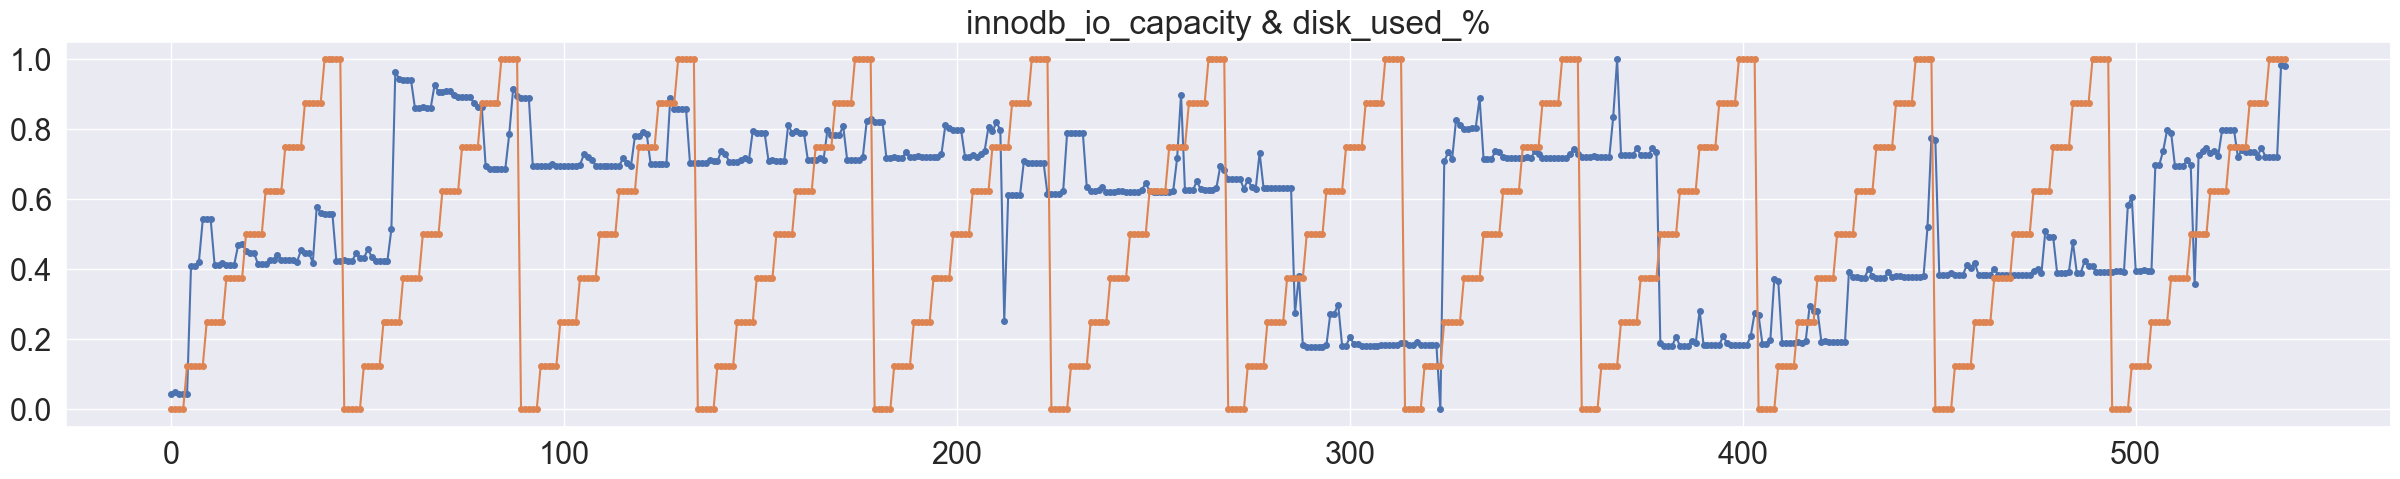




oltp_read_only_medium


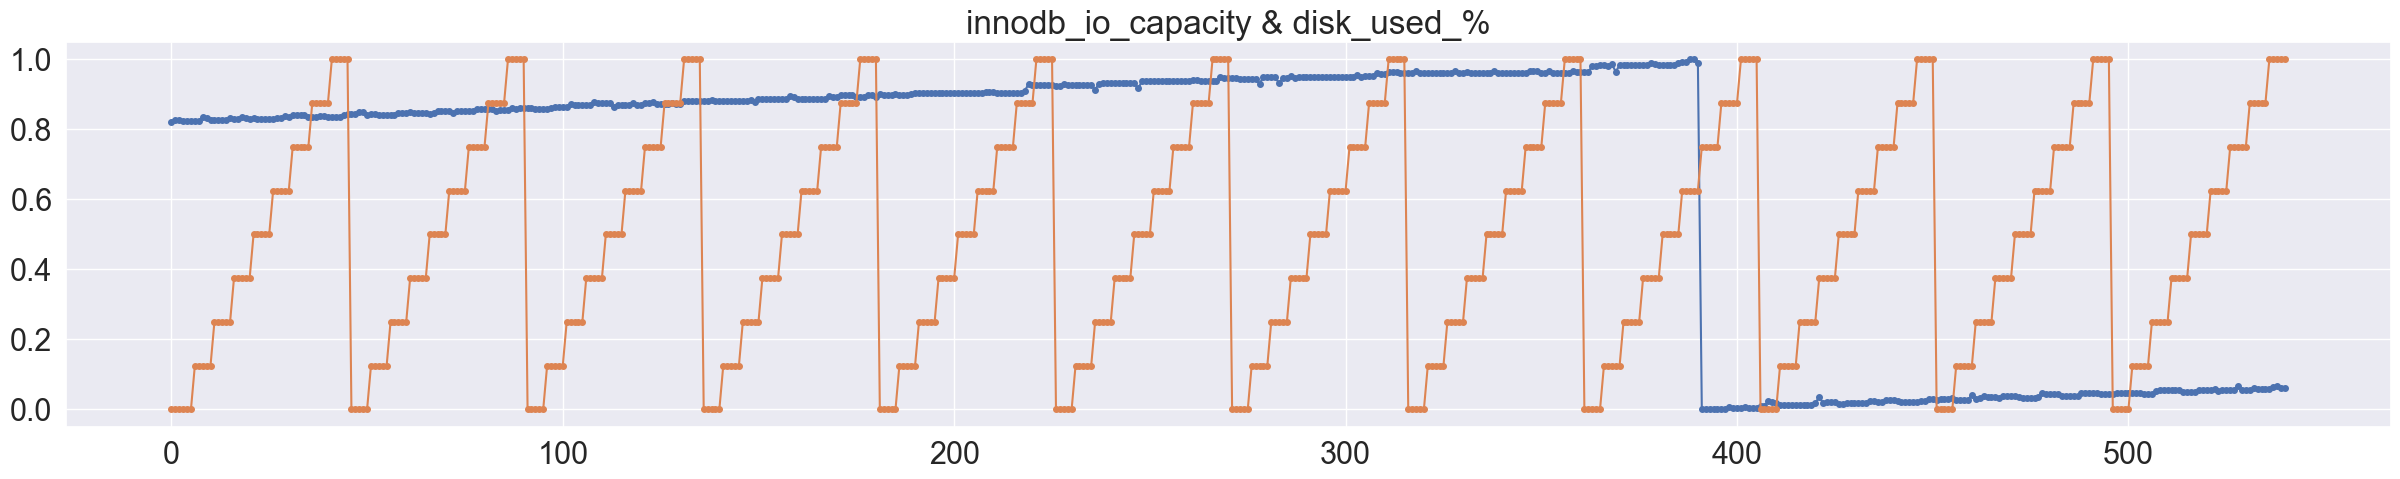

In [166]:
def normalize(df, col_name):
    max_val = max(df[col_name])
    min_val = min(df[col_name])
    return (df[col_name] - min_val) / (max_val - min_val)

for dir_name, tmp_df in zip(train_dir.iterdir(), df_lst):
    print("=====================================================")
    print(f"{dir_name.name}")
    print("=====================================================")
    tmp_df = tmp_df.loc[:, tmp_df.nunique() != 1] # 値が一定のメトリックを除く
    plt.figure(figsize=(30, 5))
    for col_name in tmp_df.columns:
        if col_name in {"disk_used_%", "innodb_io_capacity"}:
            plt.plot(range(len(tmp_df)), normalize(tmp_df, col_name), 'o-', markersize=4)
            plt.title("innodb_io_capacity & disk_used_%")
    plt.show()
    print('\n\n')
# for dir_name, tmp_df in zip(train_dir.iterdir(), df_lst):
#     print("=====================================================")
#     print(f"{dir_name.name}")
#     print("=====================================================")
#     tmp_df = tmp_df.loc[:, tmp_df.nunique() != 1] # 値が一定のメトリックを除く
#     for col_name in tmp_df.columns:
#         if col_name == "disk_used_%" or col_name in {"innodb_io_capacity", "innodb_buffer_pool"}:
#             plt.figure(figsize=(25, 5))
#             plt.plot(range(len(tmp_df)), tmp_df[col_name], 'o-')
#             plt.title(col_name)
#             plt.show()
#     print('\n\n')

In [13]:
# ワークロード間で重複していないメトリックを探索
duplicated_cols = set(df_lst[0].columns)
for tmp_df in df_lst:
    duplicated_cols &= set(tmp_df.columns)

non_duplicated_cols = set()
for tmp_df in df_lst:
    non_duplicated_cols |= set(tmp_df.columns) ^ duplicated_cols

print("non duplicated cols:")
print(non_duplicated_cols)

# 重複したメトリックを削除
if len(non_duplicated_cols) > 0:
    for tmp_df in df_lst:
        tmp_df.drop(non_duplicated_cols, axis=1, errors='ignore', inplace=True)

non duplicated cols:
set()


### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

- 特徴量を選択する際は全てのwrite, read intensiveなデータを一緒くたにして相関をみる

In [14]:
df = pd.concat(df_lst)
df_selected = df.loc[:, df.nunique() != 1]
df_selected.drop(["tps"], axis=1, inplace=True)
df.filter(like="tps")

/var/folders/y0/pn0g6kp17l99m8c60jd1rl8r0000gr/T/ipykernel_71680/1541031482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(["tps"], axis=1, inplace=True)


tps
2     474.000000
3     535.466675
4     549.466675
5     448.933319
6     451.733337
..           ...
537  1037.866699
538   683.200012
539  1019.733337
540   741.866638
541   906.133362

[5583 rows x 1 columns]

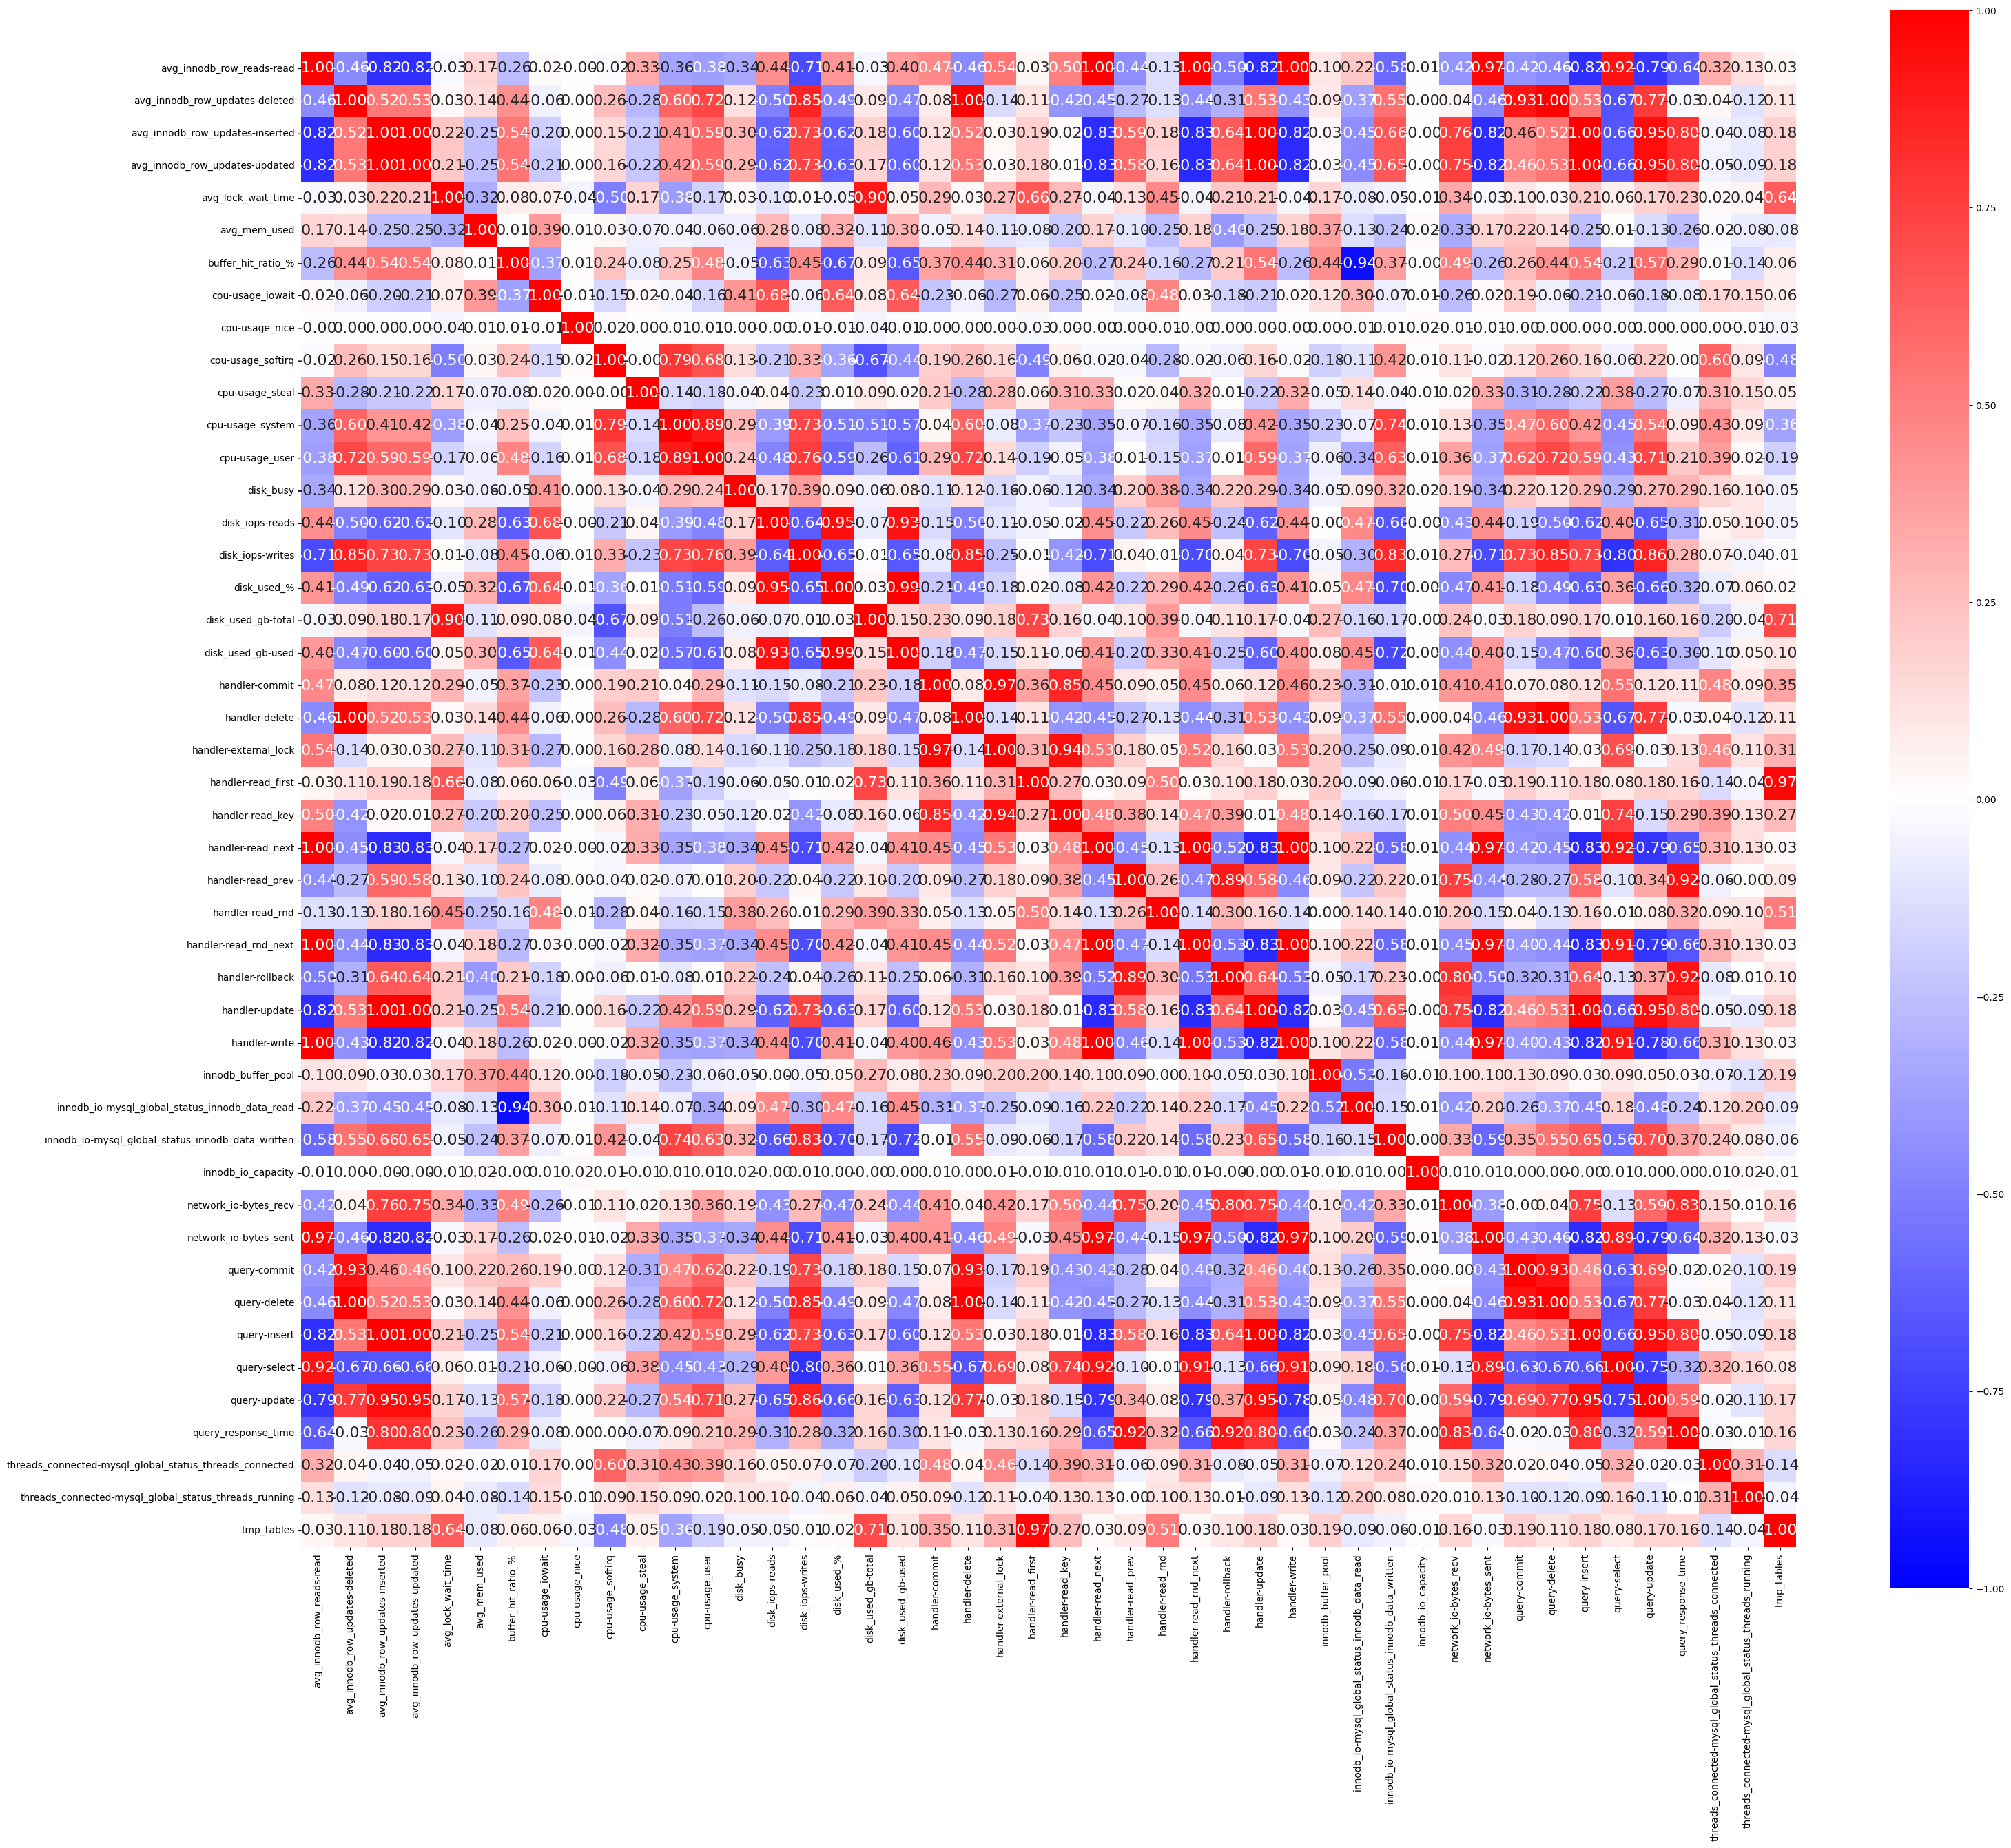

In [15]:
# 一定の値のみを取るメトリックを取り除いて相関関係をみる
df = pd.concat(df_lst)
df = df.reindex(sorted(df.columns), axis=1)
plt.figure(figsize=(35, 35))
sns.heatmap(df.loc[:, df.nunique() != 1].drop("tps", axis=1, inplace=False).corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 16}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

In [22]:
from pprint import pprint

sns.set(font_scale=2)
# df = pd.concat(df_lst[:-1])
df = pd.concat(df_lst)
df_selected = df.loc[:, df.nunique() != 1] # 値が一定のメトリックを除く
# df_selected = df.drop(["label"], axis=1, inplace=False)
df_selected = df_selected.drop(["tps"], axis=1, inplace=False)

del_lim = 35
del_num = 0
# ths = [0.95, 0.9, 0.85, 0.8]
step = 0.04
ths = np.arange(1.0, 0.95 - step, -step)
del_metrics_all = []

for th in ths:
    df_corr = df_selected.corr()
    corr_mat = df_corr.to_numpy()
    cols = df_corr.columns

    # 相関が th 以上 or -th 以下のメトリックを取り出す
    high_corrs_dict = {k: set() for k in cols}
    for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
        if i < j:
            # queryはworkloadを最もよく表しているので，消さないようにする
            if cols[i][:6] != "query-":
                high_corrs_dict[cols[i]].add(cols[j])
            if cols[j][:6] != "query-":
                high_corrs_dict[cols[j]].add(cols[i])
    del_metrics = []
    while del_num < del_lim:
        # 相関が高いメトリック間の関係数をメトリック別に列挙
        # （メトリックごとの関係数を相関係数の和で代用してもいい）
        del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
        if len(high_corrs_dict[del_metric]) == 0:
            break
        # keyを削除
        high_corrs_dict.pop(del_metric, None)
        # value(=set)の要素を削除
        for k, v_set in high_corrs_dict.items():
            if del_metric in v_set:
                v_set.discard(del_metric)
        del_metrics.append(del_metric)
        del_num += 1
    del_metrics_all += del_metrics
    df_selected.drop(del_metrics, axis=1, inplace=True)
pprint(sorted(del_metrics_all))
print(f"\nno. original metrics: {len(df.columns) - 1}") # tpsの分を引いている
print(f"no. metrics (nunique() == 1): {len(df.loc[:, df.nunique() == 1].columns)}")
pprint(df.loc[:, df.nunique() == 1].columns)
print(f"no. deleted metrics: {del_num}")
print(f"no. remaining metrics: {len(df_selected.columns)}")

['avg_innodb_row_reads-read',
 'avg_innodb_row_updates-deleted',
 'avg_innodb_row_updates-inserted',
 'avg_innodb_row_updates-updated',
 'buffer_hit_ratio_%',
 'disk_used_%',
 'disk_used_gb-used',
 'handler-commit',
 'handler-delete',
 'handler-external_lock',
 'handler-read_first',
 'handler-read_next',
 'handler-read_rnd_next',
 'handler-update',
 'network_io-bytes_sent',
 'query_response_time']

no. original metrics: 65
no. metrics (nunique() == 1): 19
Index(['slow_queries', 'no_index_used_total', 'avg_sort_merge_passes',
       'cpu-usage_irq', 'cpu-usage_guest', 'cpu-usage_guest_nice', 'swap-out',
       'swap-in', 'handler-savepoint', 'handler-discover', 'handler-read_last',
       'handler-savepoint_rollback', 'handler-mrr_init', 'handler-prepare',
       'query-create_table', 'query-alter_table', 'query-drop_index',
       'query-replace', 'query-drop_table'],
      dtype='object')
no. deleted metrics: 16
no. remaining metrics: 30


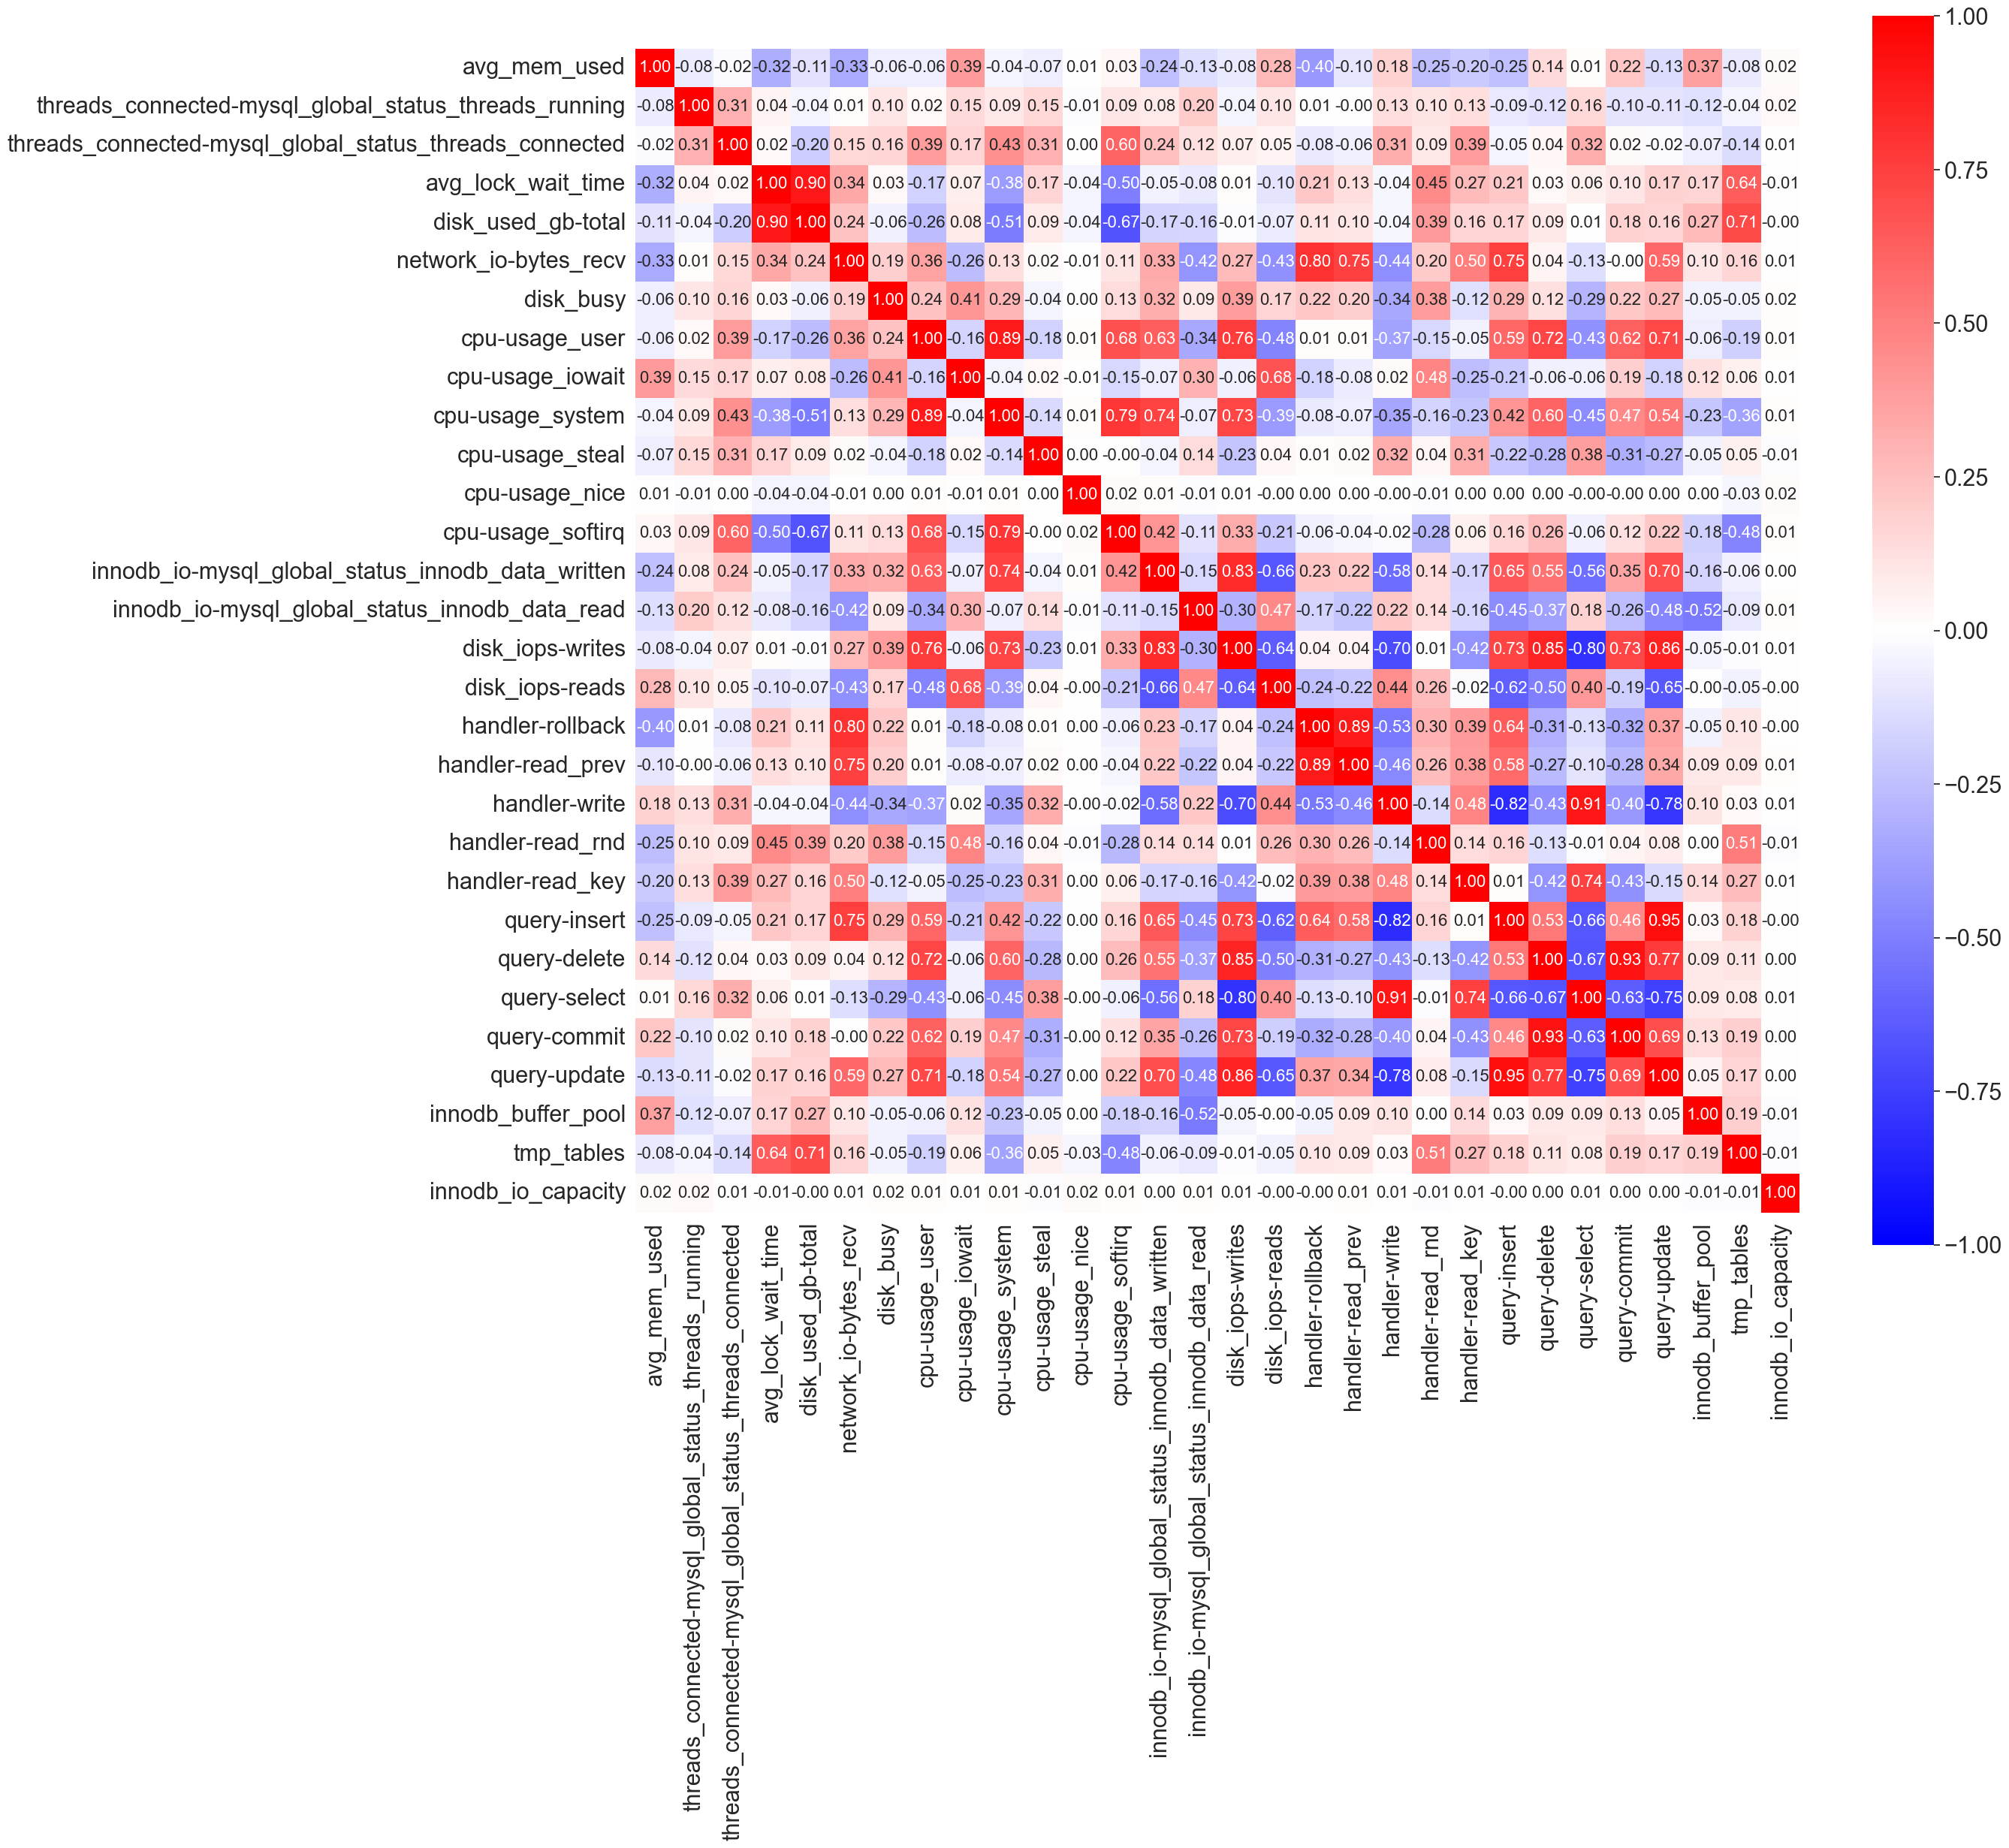

In [23]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 16}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

In [170]:
model = KMeans(n_clusters=2, random_state=100)

clusters = model.fit(df_selected)

# std_scaler = StandardScaler()
# df_std = std_scaler.fit_transform(df_selected)
# clusters = model.fit(df_std)

# mm_scaler = MinMaxScaler()
# df_normalized = mm_scaler.fit_transform(df_selected)
# clusters = model.fit(df_normalized)


NameError: name 'KMeans' is not defined

In [ ]:
for label_pred in clusters.labels_:
    print(label_pred, end=", ")
print('\n')
labels_int = labels.map({"read": 1, "write": 0}).to_numpy()
for label in labels_int:
    print(label, end=", ")

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,